In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle
#import cPickle as pickle #python2でのみ

In [4]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1')# encoding='latin1'を入れるとうまくいく

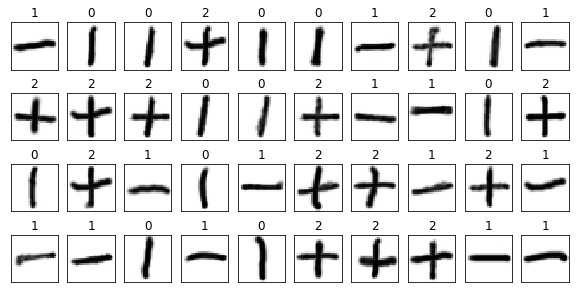

In [5]:
fig = plt.figure(figsize = (10, 5))
for i in range(40):
    subplot = fig.add_subplot(4, 10, i+1) #4行10列のi+1番目に追加
    subplot.set_xticks([]) #x軸目盛りなし
    subplot.set_yticks([]) #y軸目盛りなし
    subplot.set_title('%d' % np.argmax(labels[i]))# labels[i]の一番大きい値が入ってるindex ここでは0,1,2に対応するindexに1が入っていてそれがラベルになっている,わからないならlabel[0]とimages[0].reshape(28,28)を見る
    subplot.imshow(images[i].reshape(28, 28), vmin = 0, vmax=1, cmap=plt.cm.gray_r, interpolation='nearest')

In [6]:
def edge_filter():
    filter0 = np.array(
        [[ 2, 1, 0, -1, -2],
         [ 3, 2, 0, -2, -3],
         [ 4, 3, 0, -2, -4],
         [ 3, 2, 0, -2, -3],
         [ 2, 1, 0, -1, -2]]) / 23.0 #ブロードキャストルールで全体を/23.0
    
    filter1 = np.array(
        [[ 2, 3, 4, 3, 2],
         [ 1, 2, 3, 2, 1],
         [ 0, 0, 0, 0, 0],
         [-1,-2,0,-2,-1],
         [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5, 5, 1, 2])#フィルターの情報を格納しておく多次元リスト 5x5x1x2(フィルターサイズx入力レイヤー数x出力レイヤー数)
    filter_array[:,:,0,0] = filter0 #一番目の出力レイヤーのフィルターサイズの部分に格納
    filter_array[:,:,0,1] = filter1 #2番目の...
        
    return tf.constant(filter_array, dtype=tf.float32) # 用意した多次元リストをTensorFlowの定数値オブジェクトに変換したものを返している。
        

In [13]:
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1]) #tf.nn.conv2dに入力可能な形式に変換(画像の枚数x画像サイズ(縦x横)xレイヤー数) ここでの-1はデータ数に応じて適切なサイズに調整する

W_conv = edge_filter()
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv, strides = [1, 1, 1, 1], padding='SAME'))#tf.nn.conv2dは複数の画像データを同時入力することが可能で、
                                                                                                                                #一般に画像の枚数x画像サイズ(縦x横)xレイヤー数になっている
                                                                                                                                #x_imageに対してW_convを適用する、また結果が負になる場合は絶対値をとるというルールがあったのでtf.absで絶対値に変換している。
h_conv_cutoff = tf.nn.relu(h_conv-0.2) #-0.2することで0.2より小さい値を強制的に0にしている

h_pool = tf.nn.max_pool(h_conv_cutoff, ksize= [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')#[1,dy,dx,1] ここでは0padiing, paddingにVALIDを指定するとフィルターがはみ出す部分は計算を行わない。

In [14]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [15]:
filter_vals, conv_vals = sess.run([W_conv, h_conv_cutoff],
                                  feed_dict={x:images[:9]})#imagesから最初の９個分をplaceholderに格納して評価する